I started writing this post after reading chapter 4 of the "Practical Deep Learning for Coders" book. Chapter 4 goes under the hood of model building with neural networks and explains how the image classifiers we built in previous chapters actually work.

I intended to write a post that did the same thing with my premier league logo classifier, but immediately realized that my understanding is not where it needs to be. So, this post turned into a simple explanation of gradient descent using the technique to fit the parameters of a quadratic equation to match a random curve. I fully intend to build some version of my image classifier from scratch, but that will have to come in future posts.

The big difference between this post and the book is that I didn't want to use pytorch or fastai. I wanted to see if I could do it with stock python and numpy and thus better appreciate those libraries and why they are ultimately essential to a meaningful deep learning experience.

## Curve fitting
### Some context
Deep learning is really just parameter optimization. What does this mean, and what are some potential implications? I will reproduce the quadratic example done in the text to provide some context.

Consider a random quadratic equation that looks like this:

Text(0, 0.5, 'y')

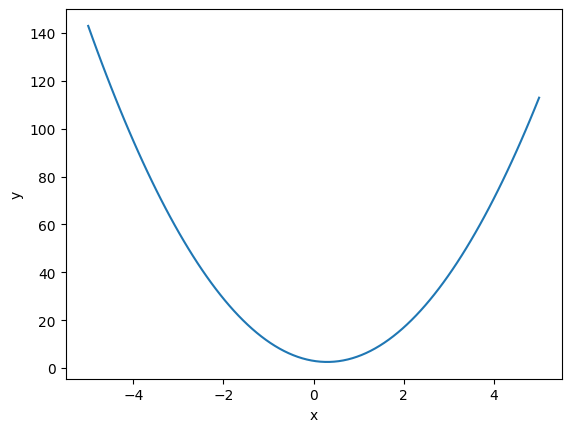

In [101]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 100)
y = 5*x**2 - 3*x + 3

plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")

Now, we know that the general form of a quadratic equation is $ax^2 + bx + c$. Therefore, we have 3 parameters that we can use to "discover" the equation that matches the graph. In other words, we want to create a model that can "look" at a graph and tell us what the equation is.

Where to begin though? Let's guess! I'm going to guess: $a = 2$ $b = 3$ and $c = 4$.

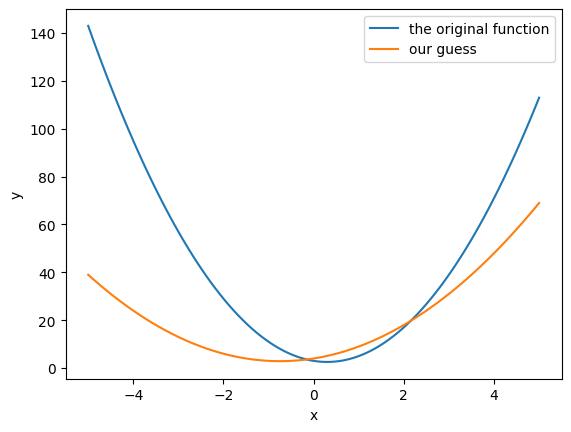

In [107]:
x = np.linspace(-5, 5, 100)
y1 = 5*x**2 - 3*x + 3
y2 = 2*x**2 + 3*x + 4

plt.plot(x, y1, label = "the original function")
plt.plot(x, y2, label = "our guess")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

Not very good! We need a way to determine how "not good" it is though. This measure of "not goodness" is usually called "loss" and it is something we want to minimize. If we can make the loss acceptably small, then we will have identified the correct parameters to form the equation that matches the graph. 
### Loss
Loss is a measure of how far our guess is from the actual value at a given point. The value of the loss by itself is not helpful at the moment. What we really want is a function that represents the loss for any point in the range of values we are interested in. This isn't too dificult. It will be the difference in values of the two functions at a given point. (I'm going to cheat here and use the real value of the function we are modeling, but try to imagine creating a table of values based on the graph and generating a similar result).

$loss = (2x^2+3x+3)-(5x^2-3x+3)$

This means the loss at $x=0$ is $(3-3) = 0$ and the loss at $x=1$ is $(2+3+3) - (5-3+3) = 3$

There is a problem though. Let's calculate the loss over a set of x values.

In [104]:
def loss(x): 
    actual = 5*x**2 - 3*x + 3
    guess = 2*x**2 + 3*x + 4
    return guess - actual
values = [loss(x) for x in range(-5,5,1)]
print(values)

[-104, -71, -44, -23, -8, 1, 4, 1, -8, -23]


We have positive *and* negative values. Ultimately, we want the average loss over the interval so that when we change our parameters we can see how it affects the total loss. If we average these values though, we get a misleading result because of the positive and negative values. 

In [108]:
# not the real loss
def avg_loss(actual, guess):
    return np.mean(guess - actual)
print(avg_loss(y1, y2))

-24.50505050505051


To solve this problem, we could take the absolute value of each loss value, but the absolute value function makes me nervous because I am planning on doing calculus soon, and the absolute value function is not differentiable everywhere. To work around this I am going to use the root mean square error function to find the true loss. My new loss function and the associated average loss now look like:

In [109]:
# the real loss
def rmse(actual, guess):
    return np.sqrt(np.mean((guess - actual)**2))
print(rmse(y1, y2))

37.773112790578644


As you can see, the actuall loss is much larger when you account for the negative values.
## Gradients
We now know the loss for our initial guess of a, b, and c. It's ~ 37.8. The question is: how do we adjust our parameters (values of a, b, and c) to improve this loss? Or, more specifically, do we increase or decrease each value and how will we know that's the right thing to do?

The answer is: the gradient. For those not in the know, a gradient is just a derivative when you have more than one variable. The cool thing about multi-variable derivatives is you can take the derivative for one variable at a time while holding all others constant.

How will a derivative help us here? Well, the derivative tells us the rate of change of a function at a specific point. So, if we know the derivative of a function, we know how the function will change and most importantly in what direction. This suggests that if we can find the derivative of our *loss* function, we will have the information we need to make the loss smaller.

In [112]:
# a neater way to generate the loss given a set of parameters.
params = [2,3,4]
def quad(a,b,c):
    return a*x**2 + b*x + c
def quad_rmse(params):
    guess = quad(*params)
    return rmse(guess, y1)
quad_rmse(params)

37.773112790578644

One of the things I learned is that computers aren't that good at calculus. They struggle to do derivatives without resorting to tricks or numerical methods. So, I cheated by computing the derivative of the RMSE function myself and inputting it directly into my gradient function.

You will notice that there are actually three derivatives within the gradient function. This is because I want to generate a value for each parameter. So, I took partial derivatives of the RMSE function with respect to a, b, and c and used the chain rule to generate the results below. This will provide me a gradient value for each parameter and give me the information I need to make adjustments.

In [113]:
def gradient(params, actual):
    guess = quad(*params)
    error = guess - actual
    rmse_value = quad_rmse(params)
    da = np.mean(error * x**2)/rmse_value
    db = np.mean(error * x)/rmse_value
    dc = np.mean(error)/rmse_value
    return np.array([da, db, dc])
abc = [5,-3,2]
actual = quad(*abc) # just to make it clear
change = gradient(params, actual)
print(change)

[-9.8813447   1.35043414 -0.62226935]


### Gradient Descent
The list above tells us how the rmse or *loss* will change if we slightly increase the values of the parameters. What we want to do now is change our parameters according to these values and see if that reduces the loss. Negative gradients imply that increasing the parameter will *lower* the loss and visa versa. Therefore, we will subtract each parameter by a small fraction of the gradient and see if that lowers the total loss. This is where the term "gradient descent" comes from.

The percentage of the gradient that we use is referred to as the *learning rate* and is a powerful mechanism in deep learning. If we choose a value that is too small then it will take too long to optimize the function. If we choose a value that is too big we may continuously overshoot the mark and never achieve the optimal solution. Choosing the appropriate learning rate for a model is one of the most important decisions in deep learning (or so I'm told).

In [114]:
params[0] -= 0.1 * change[0]
params[1] -= 0.1 * change[1]
params[2] -= 0.1 * change[2]

quad_rmse(params)

27.99569097205946

Hooray! Our loss decreased! Now we just need to repeat this process an appropriate number of times until our loss is acceptably low. How low is acceptably low? Well, we get to decide that. In this case, I decided that 25 interations or *epochs* was good enough as it reduced the loss (rmse) to 0.87. 

In [117]:
params = [2,3,4]
for i in range(24):
    change = gradient(params, actual)
    params -= 0.1 * change
    print(quad_rmse(params))

27.99569097205946
20.579700842596893
16.658160014219437
15.19511165608547
14.289258152323056
13.4377151129048
12.592348896432812
11.748233736933885
10.905012307563357
10.06287298975691
9.222095506226026
8.383063416586705
7.546319821914607
6.712658931852231
5.883288990444272
5.060138277217403
4.246472109413297
3.448245329122419
2.677372433343161
1.9604344822991577
1.3617553875218906
1.0068702630408162
0.9102456087632855
0.8735765357612059


In [118]:
print(params)

[ 4.89000272 -2.99872935  3.6827542 ]


Not bad! Those are pretty close to the values we know form the curve we started with. Let's graph a quadratic with those parameters and see how close we are.

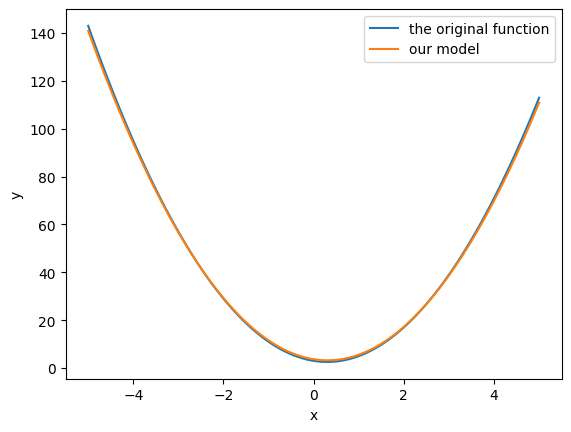

In [119]:
x = np.linspace(-5, 5, 100)
y1 = 5*x**2 - 3*x + 3
y2 = params[0]*x**2 + params[1]*x + params[2]

plt.plot(x, y1, label = "the original function")
plt.plot(x, y2, label = "our model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

It's not perfect, but I think it's close enough for most purposes. We could probably make it even better if we wanted to by running more epochs or tweaking the learning rate, but I have accomplished what I set out to. 
### What's next?
This is all well and good, but there is a big difference between fitting a curve and creating a model that can categorize images. The exciting thing is that gradient descent is the core functionality behind all of the deep learning models and I have just proven that it works. Now I need to understand how to generalize this method for any function, not just quadratics. Neural nets provide this generalization and my future posts will attempt to explain how they work. 